(Chapter 6: Stochastic Discounting)=
```{raw} jupyter
<div id="qe-notebook-header" style="text-align:right;">
        <a href="https://quantecon.org/" title="quantecon.org">
                <img style="width:250px;display:inline;" src="https://assets.quantecon.org/img/qe-menubar-logo.svg" alt="QuantEcon">
        </a>
</div>
```
# Chapter 6: Stochastic Discounting


```{contents} Contents
:depth: 2
```

In [1]:
using Pkg;
Pkg.activate("./");

using PyCall;
pygui(:tk);

  Activating project at `~/work/book-dp1/book-dp1/code-book/jl`


## plot_interest_rates.jl

In [2]:
# Nominal interest rate from https://fred.stlouisfed.org/series/GS1
# Real interest rate from https://fred.stlouisfed.org/series/WFII10
#
# Download as CSV files
#

using DataFrames, CSV, PyPlot

df_nominal = DataFrame(CSV.File("data/GS1.csv"))
df_real = DataFrame(CSV.File("data/WFII10.csv"))

function plot_rates(df; fontsize=16, savefig=true)
    r_type = df == df_nominal ? "nominal" : "real"
    fig, ax = plt.subplots(figsize=(9, 5))
    ax.plot(df[!, 1], df[!, 2], label=r_type*" interest rate")
    ax.plot(df[!, 1], zero(df[!, 2]), c="k", ls="--")
    ax.set_xlim(df[1, 1], df[end, 1])
    ax.legend(fontsize=fontsize, frameon=false)
    if savefig
        fig.savefig("./figures/plot_interest_rates_"*r_type*".pdf")
    end
end


plot_rates (generic function with 1 method)

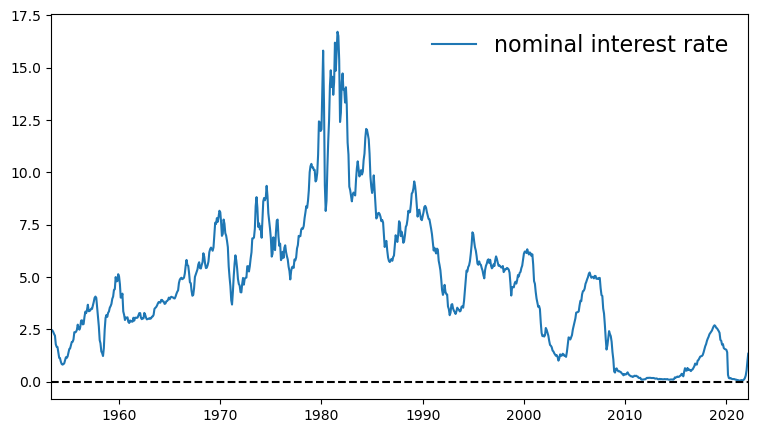

In [3]:
plot_rates(df_nominal, savefig=true)

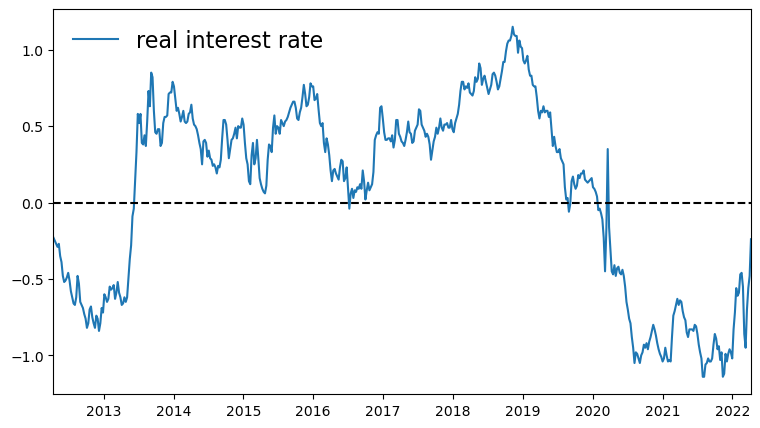

In [4]:
plot_rates(df_real, savefig=true)

## pd_ratio.jl

In [5]:
"""
Price-dividend ratio in a model with dividend and consumption growth.

"""

using QuantEcon, LinearAlgebra

"Creates an instance of the asset pricing model with Markov state."
function create_asset_pricing_model(;
        n=200,              # state grid size
        ρ=0.9, ν=0.2,       # state persistence and volatility
        β=0.99, γ=2.5,      # discount and preference parameter
        μ_c=0.01, σ_c=0.02, # consumption growth mean and volatility
        μ_d=0.02, σ_d=0.1)  # dividend growth mean and volatility
    mc = tauchen(n, ρ, ν)
    x_vals, P = exp.(mc.state_values), mc.p
    return (; x_vals, P, β, γ, μ_c, σ_c, μ_d, σ_d)
end

" Build the discount matrix A. "
function build_discount_matrix(model)
    (; x_vals, P, β, γ, μ_c, σ_c, μ_d, σ_d) = model
    e = exp.(μ_d - γ*μ_c + (γ^2*σ_c^2 + σ_d^2)/2 .+ (1-γ)*x_vals)
    return β * e .* P
end

"Compute the price-dividend ratio associated with the model."
function pd_ratio(model)
    (; x_vals, P, β, γ, μ_c, σ_c, μ_d, σ_d) = model
    A = build_discount_matrix(model)
    @assert maximum(abs.(eigvals(A))) < 1 "Requires r(A) < 1."
    n = length(x_vals)
    return (I - A) \ (A * ones(n))
end


# == Plots == #

using PyPlot
using LaTeXStrings
PyPlot.matplotlib[:rc]("text", usetex=true) # allow tex rendering
fontsize=16

default_model = create_asset_pricing_model()


function plot_main(; μ_d_vals = (0.02, 0.08),
                     savefig=false, 
                     figname="./figures/pd_ratio_1.pdf")
    fig, ax = plt.subplots(figsize=(9, 5.2))

    for μ_d in μ_d_vals
        model = create_asset_pricing_model(μ_d=μ_d)
        (; x_vals, P, β, γ, μ_c, σ_c, μ_d, σ_d) = model
        v_star = pd_ratio(model)
        ax.plot(x_vals, v_star, lw=2, alpha=0.6, label=L"\mu_d="*"$μ_d")
    end

    ax.legend(frameon=false, fontsize=fontsize)
    ax.set_xlabel(L"x", fontsize=fontsize)
    if savefig
        fig.savefig(figname)
    end
end



plot_main (generic function with 1 method)

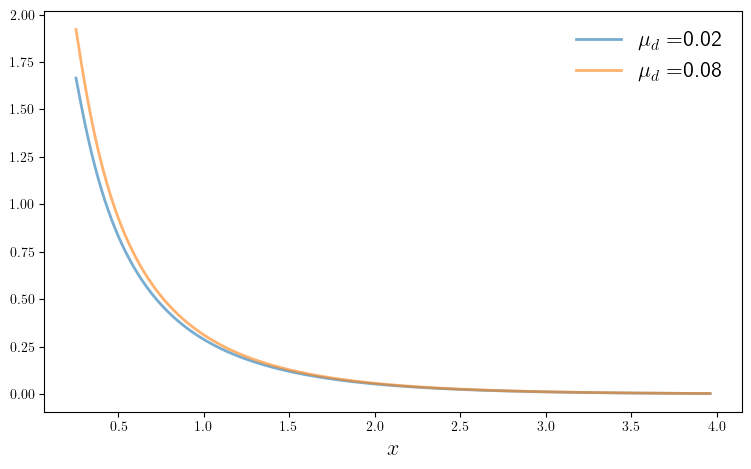

In [6]:
plot_main(savefig=true)

## inventory_sdd.jl

In [7]:
"""
Inventory management model with state-dependent discounting.  
The discount factor takes the form β_t = Z_t, where (Z_t) is 
a discretization of the Gaussian AR(1) process 

    X_t = ρ X_{t-1} + b + ν W_t.

"""

include("s_approx.jl")
using LinearAlgebra, Distributions, QuantEcon

function create_sdd_inventory_model(; 
            ρ=0.98, ν=0.002, n_z=20, b=0.97,  # Z state parameters
            K=40, c=0.2, κ=0.8, p=0.6)        # firm and demand parameters
    ϕ(d) = (1 - p)^d * p                      # demand pdf
    y_vals = collect(0:K)                     # inventory levels
    mc = tauchen(n_z, ρ, ν)
    z_vals, Q = mc.state_values .+ b, mc.p
    ρL = maximum(abs.(eigvals(z_vals .* Q)))     
    @assert  ρL < 1 "Error: ρ(L) ≥ 1."    # check ρ(L) < 1
    return (; K, c, κ, p, ϕ, y_vals, z_vals, Q)
end

m(y) = max(y, 0)  # Convenience function

"The function B(x, a, v) = r(x, a) + β(x) Σ_x′ v(x′) P(x, a, x′)."
function B(x, i_z, a, v, model; d_max=100)
    (; K, c, κ, p, ϕ, y_vals, z_vals, Q) = model
    z = z_vals[i_z]
    revenue = sum(min(x, d)*ϕ(d) for d in 0:d_max)
    current_profit =  revenue - c * a - κ * (a > 0)
    cv = 0.0
    for i_z′ in eachindex(z_vals)
        for d in 0:d_max
            cv += v[m(x - d) + a + 1, i_z′] * ϕ(d) * Q[i_z, i_z′]
        end
    end
    return current_profit + z * cv
end

"The Bellman operator."
function T(v, model)
    (; K, c, κ, p, ϕ, y_vals, z_vals, Q) = model
    new_v = similar(v)
    for (i_z, z) in enumerate(z_vals)
        for (i_y, y) in enumerate(y_vals)
            Γy = 0:(K - y) 
            new_v[i_y, i_z], _ = findmax(B(y, i_z, a, v, model) for a in Γy)
        end
    end
    return new_v
end

"Get a v-greedy policy.  Returns a zero-based array."
function get_greedy(v, model)
    (; K, c, κ, p, ϕ, y_vals, z_vals, Q) = model
    n_z = length(z_vals)
    σ_star = zeros(Int32, K+1, n_z)
    for (i_z, z) in enumerate(z_vals)
        for (i_y, y) in enumerate(y_vals)
            Γy = 0:(K - y) 
            _, i_a = findmax(B(y, i_z, a, v, model) for a in Γy)
            σ_star[i_y, i_z] = Γy[i_a]
        end
    end
    return σ_star
end


"Use successive_approx to get v_star and then compute greedy."
function solve_inventory_model(v_init, model)
    (; K, c, κ, p, ϕ, y_vals, z_vals, Q) = model
    v_star = successive_approx(v -> T(v, model), v_init)
    σ_star = get_greedy(v_star, model)
    return v_star, σ_star
end


# == Plots == # 

using PyPlot
using PyPlot
using LaTeXStrings
PyPlot.matplotlib[:rc]("text", usetex=true) # allow tex rendering

# Create an instance of the model and solve it
model = create_sdd_inventory_model()
(; K, c, κ, p, ϕ, y_vals, z_vals, Q) = model
n_z = length(z_vals)
v_init = zeros(Float64, K+1, n_z)
println("Solving model.")
v_star, σ_star = solve_inventory_model(v_init, model)
z_mc = MarkovChain(Q, z_vals)

"Simulate given the optimal policy."
function sim_inventories(ts_length; X_init=0)
    i_z = simulate_indices(z_mc, ts_length, init=1)
    G = Geometric(p)
    X = zeros(Int32, ts_length)
    X[1] = X_init
    for t in 1:(ts_length-1)
        D′ = rand(G)
        X[t+1] = m(X[t] - D′) + σ_star[X[t] + 1, i_z[t]]
    end
    return X, z_vals[i_z]
end

function plot_ts(; ts_length=400,
                   fontsize=16, 
                   figname="./figures/inventory_sdd_ts.pdf",
                   savefig=false)
    X, Z = sim_inventories(ts_length)
    fig, axes = plt.subplots(2, 1, figsize=(9, 5.5))

    ax = axes[1]
    ax.plot(X, label="inventory", alpha=0.7)
    ax.set_xlabel(L"t", fontsize=fontsize)
    ax.legend(fontsize=fontsize, frameon=false)
    ax.set_ylim(0, maximum(X)+3)

    # calculate interest rate from discount factors
    r = (1 ./ Z) .- 1

    ax = axes[2]
    ax.plot(r, label=L"r_t", alpha=0.7)
    ax.set_xlabel(L"t", fontsize=fontsize)
    ax.legend(fontsize=fontsize, frameon=false)
    #ax.set_ylim(0, maximum(X)+8)

    plt.tight_layout()
    if savefig == true
        fig.savefig(figname)
    end
end



Solving model.


Completed iteration 25 with error 0.5612439473730824.


Completed iteration 50 with error 0.33434255762250586.


Completed iteration 75 with error 0.16028703786853526.


Completed iteration 100 with error 0.09011797568146562.


Completed iteration 125 with error 0.049802462719462426.


Completed iteration 150 with error 0.027161672509890877.


Completed iteration 175 with error 0.014707249128775857.


Completed iteration 200 with error 0.007932294742488466.


Completed iteration 225 with error 0.004269072929773188.


Completed iteration 250 with error 0.0022948708510455162.


Completed iteration 275 with error 0.001232831534892398.


Completed iteration 300 with error 0.0006620584060144097.


Completed iteration 325 with error 0.0003554717469143043.


Completed iteration 350 with error 0.00019083936177111127.


Completed iteration 375 with error 0.00010244851192453552.


Completed iteration 400 with error 5.499580430523565e-5.


Completed iteration 425 with error 2.952200834016594e-5.


Completed iteration 450 with error 1.5847402693225376e-5.


Completed iteration 475 with error 8.506835150967618e-6.


Completed iteration 500 with error 4.566428842167625e-6.


Completed iteration 525 with error 2.4512335414783593e-6.


Completed iteration 550 with error 1.3158073528529712e-6.


Terminated successfully in 563 iterations.


plot_ts (generic function with 1 method)

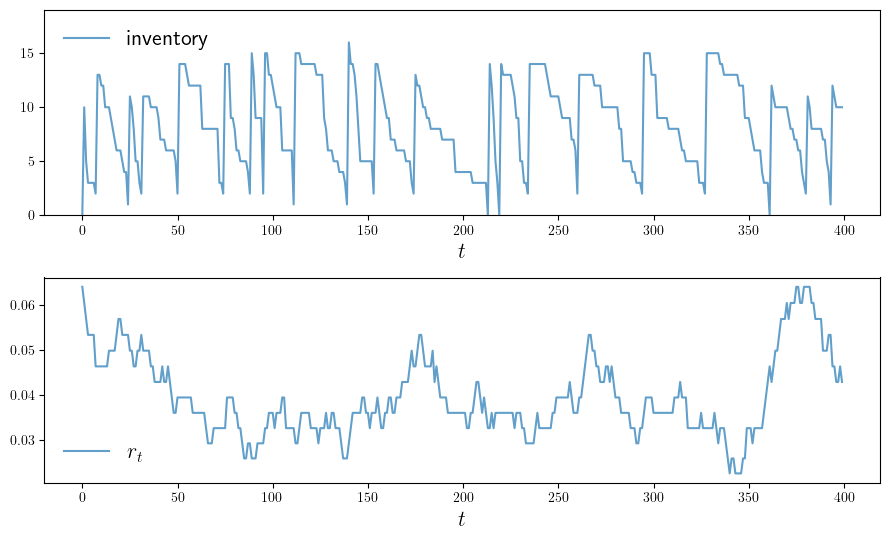

In [8]:
plot_ts(savefig=true)